In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import gensim
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models import LdaModel

plt.style.use('seaborn')

# spanish stop words
stop_words = set(stopwords.words('spanish'))
stop_words = ['t', 'si', 'q', 'https', 'co', 'solo', 'ser', 'bien', 
            'así', 'ma', 'mas', 'igual', 'va', 'después',
            'hacer', 'hace', 'creo'] + list(stop_words)

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# **Paths a los datos**

In [2]:
#data_paths = ['data/gabrielboric.csv', 'data/santiago_covid_2020.csv', 'data/santiago_pinera_2020.csv']
data_paths = ['data/seven_days_tweets.csv']

# **Métodos útiles**

In [3]:
def bar_plot(x, y, title, file_name):
    """useful method to generate and save bar plots.

    Args:
        x (str, float?): names.
        y (float): value of each name.
        title (str): title to put on the plot.
        file_name (str): fiel name to save the plot
    """
    plt.bar(x, y)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig("imgs/segunda_avance/" + file_name)
    plt.show()

def delete_chars(text, unwanted_chars):
    """
    useful method to replace a list of chars on text.
    return:
        (str) the same str without the chars in chars.
    """
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

def preprocess_tweet(tweet):
    """
    Replaces unwanted characters and performs
    a preprocessing.
    input: 
        (str) tweet.
    return:
        (str[]) final: list of words.
    """
    unwanted = ['#', ',', '.', '!', '?', '¿', '¡', '(',\
                ')', '-', '=', 'jaja', 'jajaja']
    final = delete_chars(tweet, unwanted).split()
    final = [w.lower() for w in final]
    # Asumo que no hay @´s de dos caracteres como @ho.
    final = [w for w in final if w not in stop_words and len(w) > 3]
    # Se eliminan links
    final = [w for w in final if w[:4] != 'http']
    #final = [w for w in final if w[:1] != '@']
    return final

def bar_plot_(top_topics):
    """Plots the distribution for each topic.

    Args:
        top_topics ([type]): From lda_model.
    """
    # Correr sólo para generar y guardar plots.
    for ind, t in enumerate(top_topics):
        bar_plot([x[1] for x in t[0]], [x[0] for x in t[0]], \
                "Probabilidades por palabra: tópico {}. \n coherencia: {}".format(ind, round(t[1],2)), \
                "boric_barplot{}.png".format(ind))

def preprocessed_tweets(data_paths):
    """Preprocess for twitter data.

    Args:
        data_paths (str[]): list of paths to raw twitter data csv. Must have ['date', 'tweet'] columns.

    Returns:
        pd.DataFrame: preprocessed twitter data.
    """
    # Read and preprocecss data. El orden de los procesos importa.
    data = pd.concat([pd.read_csv(p)[['date', 'tweet']] for p in data_paths]).reset_index()
    data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data['date']]
    processed_tweets = data['tweet'].map(preprocess_tweet)
    dropers = []
    for ind, tweet in enumerate(processed_tweets):
        if len(tweet) < 5:
            dropers.append(ind) 
    return processed_tweets.drop(dropers) 
    

# **Métodos para el modelo**

In [4]:
def run_model(bow_corpus, dictionary, num_topics, alpha, eta):
    """Runs the model and print top topic.

    Args:
        bow_corpus ([type]): List of tweets as bow
        dictionary ([type]): dictionary form of the corpus.
        num_topics (int): number of topics.
        alpha ([float]): a-priori belief for each topic probability. 
        eta ([float, float]): a-priori belief for words probabiliry
                                on each topic.

    Returns:
        [type]: [description]
    """
    # Run model.
    lda_model = LdaModel(corpus=bow_corpus,
                        id2word=dictionary,
                        alpha=alpha,
                        eta=eta,
                        num_topics=num_topics,
                        random_state=1)
    # Get top topics from the model.
    top_topics = lda_model.top_topics(corpus=bow_corpus, coherence='u_mass')
    # Print all the important info.
    print('-------------------------------------------------------------')
    print('Dictionary len: ', len(dictionary))
    print('Amount of tweets: ', len(bow_corpus))
    print('-------------------------------------------------------------')
    for idx, topic in lda_model.print_topics(-1):
        print('TOPIC: {} \nWORDS: {}'.format(idx, topic))
    print('-------------------------------------------------------------')
    print('Average topic coherence', np.mean([t[1] for t in top_topics]))
    print('-------------------------------------------------------------')
    bar_plot_(top_topics)


# Method to calculate coherence measure for each hyperparamaters array.
def coherence_value(bow_corpus, dictionary, num_topics, alpha, eta):
    """Given the hyperparameters, computes a lda_model and calculates
    its 'u_mass' metric.

    Args:
        bow_corpus ([type]): List of tweets as bow
        dictionary ([type]): dictionary form of the corpus.
        num_topics (int): number of topics.
        alpha ([float]): a-priori belief for each topic probability. 
        eta ([float, float]): a-priori belief for words probabiliry
                                on each topic. 

    Returns:
        [float]: coherence measure 'u_mass'.
    """
    lda_model = LdaModel(corpus=bow_corpus,
                        id2word=dictionary,
                        alpha=alpha,
                        eta=eta,
                        num_topics=num_topics,
                        random_state=1)
    top_topics = lda_model.top_topics(corpus=bow_corpus, coherence='u_mass')
    
    return np.mean([t[1] for t in top_topics])



#mini test: 
#print(coherence_value(bow_corpus, dictionary, 5, 'auto', 'auto'))

def parameteres_optimization(topics_arr, alpha_arr, eta_arr, file_name):
    """Iterates over the array's product set, runs the model and save
    the obtained results on a csv.

    Args:
        topics_arr (int[]): number of topics.
        alpha_arr (obj[]): alpha.
        eta_arr (obj[]): eta.
        file_name (str): File name.
    """

    # Guardamos los resultados en un df que se pasará a csv.
    df_results = pd.DataFrame(columns=['parameters', 'u_mass'])
    parameters = []
    u_mass = []

    for num in tqdm(topics_arr):
        for alpha in alpha_arr:
            for eta in eta_arr:
                parameters.append((num, alpha, eta))
                u_mass.append(coherence_value(bow_corpus, dictionary, num, alpha, eta))

    df_results['parameters'] = parameters
    df_results['u_mass'] = u_mass

    # Save dataframe to csv file.
    if file_name: df_results.to_csv(file_name + '.csv')

    # Print data frame.
    print(df_results)

    # Return data frame.
    return df_results

# **Optimización hiperparámetros**

100%|██████████| 1/1 [02:31<00:00, 151.71s/it]


                   parameters    u_mass
0             (5, auto, auto) -9.184483
1        (5, auto, symmetric) -9.184483
2                (5, auto, 1) -8.809146
3                (5, auto, 2) -8.932425
4                (5, auto, 3) -8.605767
5        (5, symmetric, auto) -8.794592
6   (5, symmetric, symmetric) -8.794592
7           (5, symmetric, 1) -8.768383
8           (5, symmetric, 2) -8.610768
9           (5, symmetric, 3) -8.572624
10               (5, 1, auto) -8.788732
11          (5, 1, symmetric) -8.788732
12                  (5, 1, 1) -9.159057
13                  (5, 1, 2) -9.155462
14                  (5, 1, 3) -8.895629
15               (5, 2, auto) -9.039119
16          (5, 2, symmetric) -9.039119
17                  (5, 2, 1) -9.267746
18                  (5, 2, 2) -9.311857
19                  (5, 2, 3) -9.409856
20               (5, 3, auto) -9.778566
21          (5, 3, symmetric) -9.778566
22                  (5, 3, 1) -9.758822
23                  (5, 3, 2) -9.645456


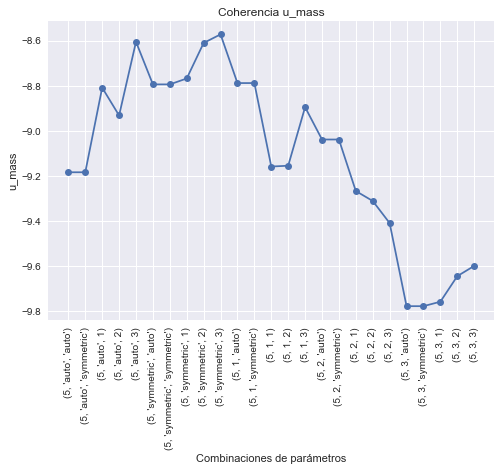

In [5]:
# Esta celda sirve para variar los arreglos, correr todo y graficar.

# id de la iteración.
i = 0
# Read and preprocess data.
processed_tweets = preprocessed_tweets(data_paths)
# Se crea el diccionario y no se filtran palabras
dictionary = gensim.corpora.Dictionary(processed_tweets)

dictionary.filter_extremes(no_below=100, no_above=1)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

# Arrays.
alpha_arr = ['auto', 'symmetric', 1, 2, 3]
eta_arr = ['auto', 'symmetric', 1, 2, 3]
file_name = 'mix_param_optimization' + str(i) + '_informe'
df_results = parameteres_optimization([5], alpha_arr, eta_arr, file_name)

# Sacamos valores para graficar.
str_param = ['{}'.format(p) for p in df_results['parameters']]
plt.plot(str_param, df_results['u_mass'], '-o')
plt.xticks(rotation=90)
plt.title('Coherencia u_mass')
plt.ylabel('u_mass')
plt.xlabel('Combinaciones de parámetros')
plt.show()


# **Celda para correr un sólo modelo**

In [7]:
# Esta celda es para corre el método run_model()

# Read and preprocess data.
processed_tweets = preprocessed_tweets(data_paths)
# Se crea el diccionario sin filtrar; modelo base.
dictionary = gensim.corpora.Dictionary(processed_tweets)
print('largo original: ', len(dictionary))
dictionary.filter_extremes(no_below=100, no_above=1)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

num_topics = 5
alpha = 'symmetric'
eta = 3
#run_model(bow_corpus, dictionary, num_topics, alpha, eta)

largo original:  80920
